### Importing the libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import LSTM, Dense, Bidirectional, Input, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, BatchNormalization, MaxPool1D
from keras.models import Model, Sequential
from keras.utils import to_categorical

from tensorflow.keras.utils import plot_model

import re, string, unicodedata, os
from string import punctuation

from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import torch
import transformers
import gensim

In [2]:
df=pd.read_csv('IMDB Dataset.csv', quotechar='"')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Text preprocessing

In [3]:
# check duplicate review
df[df.duplicated()]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [4]:
# remove duplicated reviews
df.drop_duplicates(keep='first', inplace=True)

In [5]:
df.sentiment.value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

In [6]:
# download the stopwords corpus
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Remove tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

# Apply function on review column
df['review']=df['review'].apply(denoise_text)

<ipython-input-7-678b68c61eb8>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [8]:
# Replace the sentiment with integer
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1


### BERT Model

In [9]:
df_cut = df[:15000]

In [10]:
# Split the dataset to training set and testing set
x_train,x_test,y_train,y_test = train_test_split(df_cut.review,df_cut.sentiment,random_state = 0 , stratify = df_cut.sentiment)

Fast encoding

In [11]:
from tokenizers import BertWordPieceTokenizer

# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)

# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [12]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []

    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

In [13]:
x_train = fast_encode(x_train.values, fast_tokenizer, maxlen=400)
x_test = fast_encode(x_test.values, fast_tokenizer, maxlen=400)

In [14]:
def build_model(transformer, max_len=400):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)

    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [15]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [16]:
model = build_model(bert_model, max_len=400)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 400)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   66362880  
 stilBertModel)              hidden_state=(None, 400             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense (Dense)               (None, 1)                 769   

In [18]:
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 10)

Epoch 1/10
352/352 [==============================] - 167s 474ms/step - loss: 0.4901 - accuracy: 0.7292 - val_loss: 0.3616 - val_accuracy: 0.8328
Epoch 2/10
352/352 [==============================] - 166s 470ms/step - loss: 0.2907 - accuracy: 0.8786 - val_loss: 0.3283 - val_accuracy: 0.8632
Epoch 3/10
352/352 [==============================] - 166s 471ms/step - loss: 0.1875 - accuracy: 0.9275 - val_loss: 0.4146 - val_accuracy: 0.8501
Epoch 4/10
352/352 [==============================] - 165s 470ms/step - loss: 0.1078 - accuracy: 0.9598 - val_loss: 0.4612 - val_accuracy: 0.8541
Epoch 5/10
352/352 [==============================] - 166s 470ms/step - loss: 0.0601 - accuracy: 0.9794 - val_loss: 0.5198 - val_accuracy: 0.8547
Epoch 6/10
352/352 [==============================] - 165s 470ms/step - loss: 0.0446 - accuracy: 0.9849 - val_loss: 0.5554 - val_accuracy: 0.8547
Epoch 7/10
352/352 [==============================] - 165s 470ms/step - loss: 0.0259 - accuracy: 0.9925 - val_loss: 0.5597 -

### Analysis after training of model

In [19]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

118/118 [==============================] - 17s 143ms/step - loss: 0.7879 - accuracy: 0.8584
Accuracy of the model on Testing Data is -  85.83999872207642 %


In [20]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('bert_history.csv', index=False)

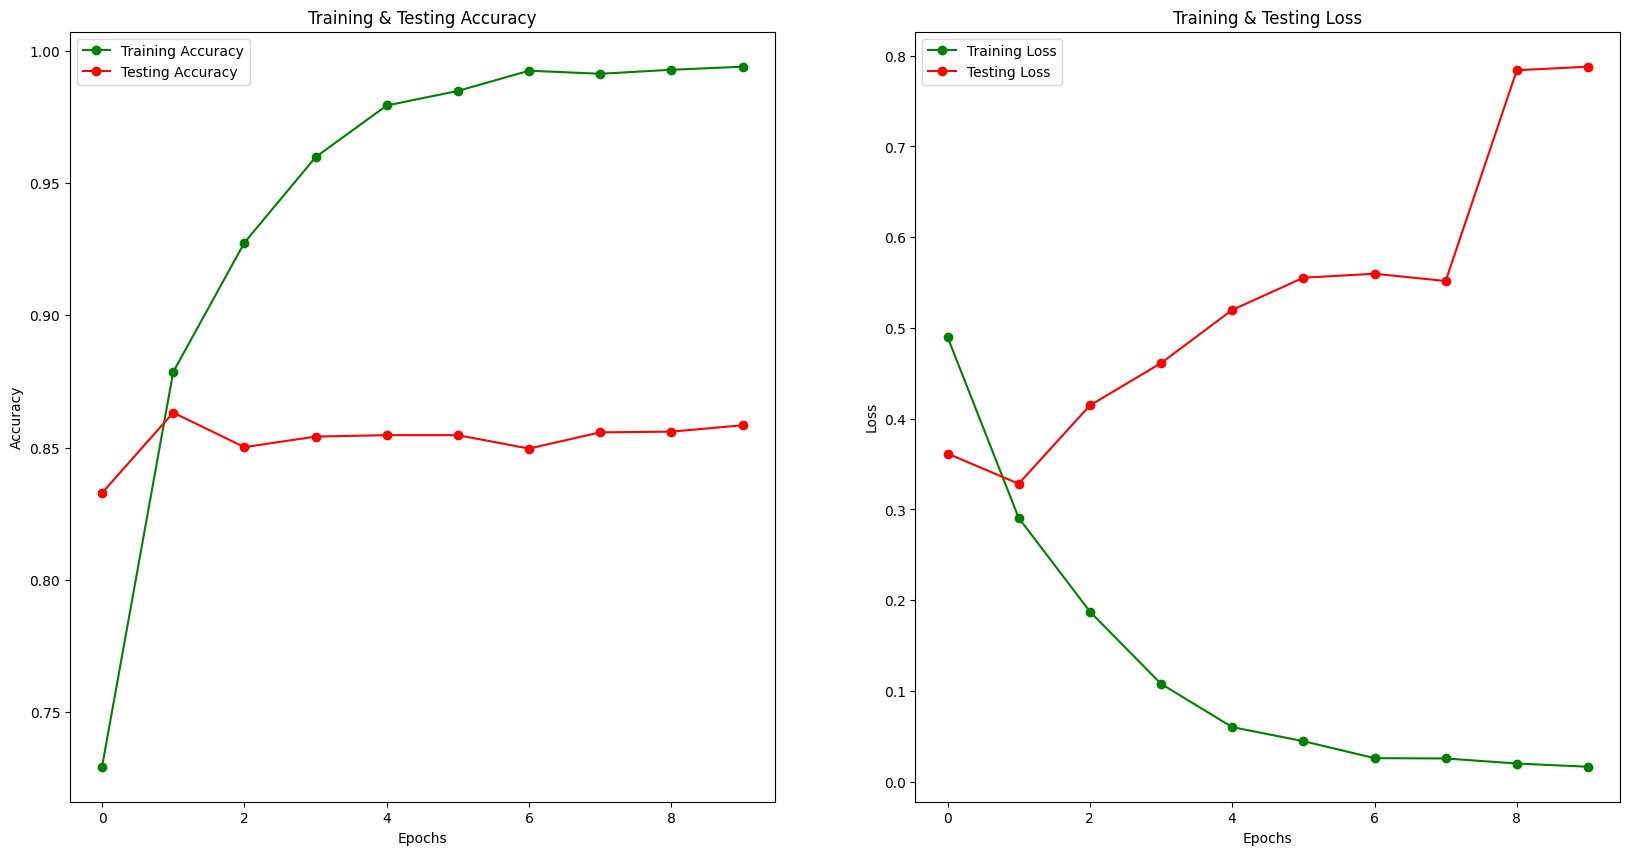

In [23]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [24]:
pred = model.predict(x_test)
pred[:5]

118/118 [==============================] - 18s 138ms/step


array([[5.4729178e-05],
       [9.9962902e-01],
       [9.9993753e-01],
       [9.9987078e-01],
       [5.7793673e-06]], dtype=float32)

In [25]:
pred = np.round(pred).astype(int)
pred[:5]

array([[0],
       [1],
       [1],
       [1],
       [0]])

In [26]:
print(classification_report(y_test, pred, target_names = ['Bad Reviews','Good Reviews']))

              precision    recall  f1-score   support

 Bad Reviews       0.84      0.90      0.87      1899
Good Reviews       0.89      0.82      0.85      1851

    accuracy                           0.86      3750
   macro avg       0.86      0.86      0.86      3750
weighted avg       0.86      0.86      0.86      3750



In [27]:
#calculating precision and reall
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')
print("Precision: ", round(precision*100,4),'%')
print("Recall: ", round(recall*100,4),'%')
print("f1_score: ", round(f1*100,4), '%')

Precision:  86.0194 %
Recall:  85.84 %
f1_score:  85.8144 %


In [28]:
cm = confusion_matrix(y_test,pred)
cm

array([[1702,  197],
       [ 334, 1517]])

Text(95.72222222222221, 0.5, 'Actual')

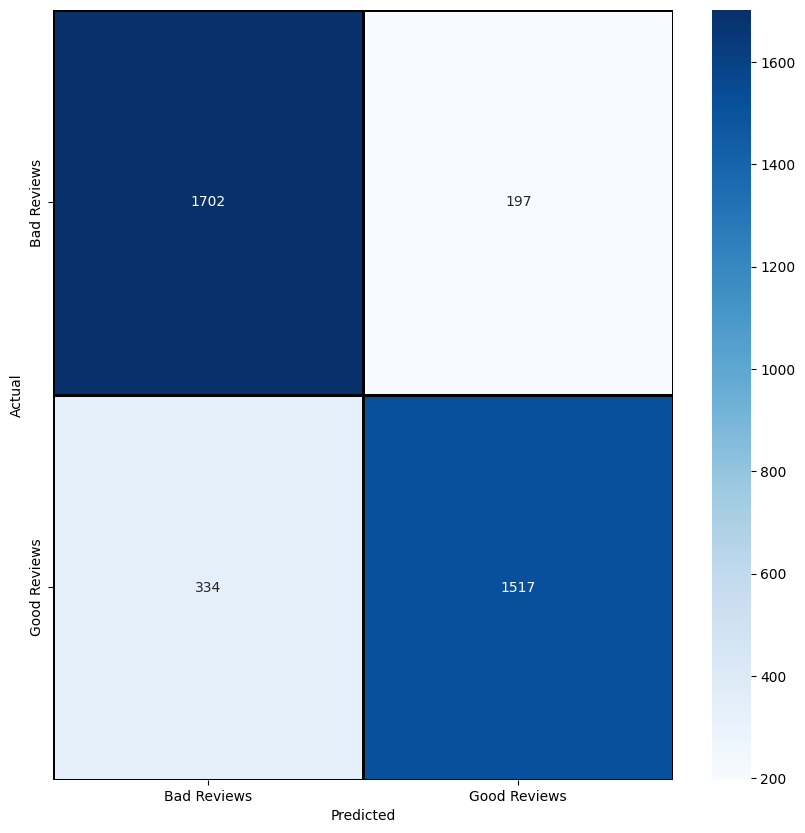

In [29]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")